<a href="https://colab.research.google.com/github/MbProg/AutoTextSum/blob/master/UnivariateStatistical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [0]:
from statsmodels.tsa.stattools import adfuller

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import and plot data

           value  is_anomaly
timestamp                   
1              5           0
2             60           0
3             88           0
4             84           0
5            111           0
Anomaly shape: (5, 2)


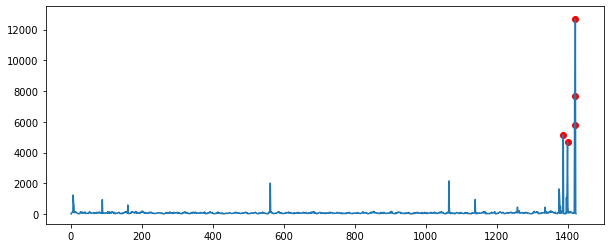

In [0]:
from pandas import read_csv
import matplotlib.pyplot as plt

df = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
print(df.head())
df_anomaly = df.loc[df['is_anomaly']==1.]
print('Anomaly shape:',df_anomaly.shape)
plt.figure(figsize=(10,4))
plt.plot(df.index,df['value'])
plt.scatter(df_anomaly.index, df_anomaly['value'],color='red')
plt.show()

# Box - Jenkins Method:


1.   Identification
2.   Estimation
3.   Diagnostic Checking



## Identification

### Unit Root Testing

#### Orginal Data

In [0]:
from statsmodels.tsa.stattools import adfuller
X = df.iloc[:,0].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))  

ADF Statistic: 3.176938
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


#### Logged Data

In [0]:
from numpy import log
X = df.iloc[:,0].values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.869057
p-value: 0.002275
	1%: -3.435
	5%: -2.864
	10%: -2.568


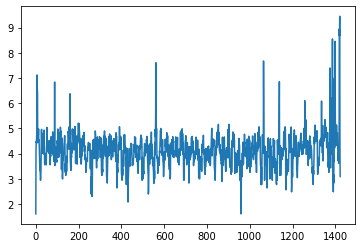

In [0]:
plt.plot(X)

#### Differenced Data

In [0]:
X = df.iloc[:,0].diff().values
X[0] = 0
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.011125
p-value: 0.000000
	1%: -3.435
	5%: -2.864
	10%: -2.568


### Scatter Plot Correlation between lags

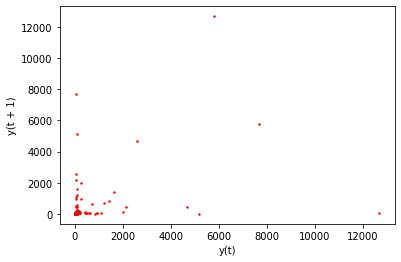

In [0]:
from pandas.plotting import lag_plot
lag_plot(df.iloc[:,0],lag=1,s=2,c='red')


### Correlation between lags

In [0]:
import pandas as pd
values = pd.DataFrame(df.iloc[:,0].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.41531
t+1  0.41531  1.00000


### ACF Plot 

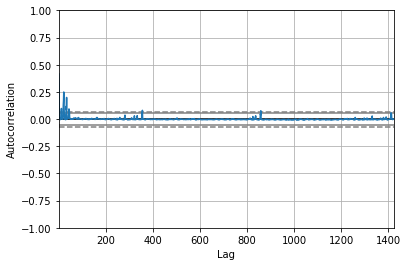

In [0]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
series =pd.DataFrame(df.iloc[:,0].values)
autocorrelation_plot(series)
pyplot.show()

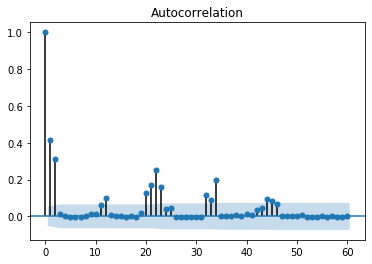

In [0]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = pd.DataFrame(df.iloc[:,0].values)
plot_acf(series, lags=60)
pyplot.show()

# Forecasting

## Create Persistent Model

Train shape (1415,)  - Test shape: [   42.    54.    37.  7665.  5781. 12673.    67.]
Test RMSE: 6189.267


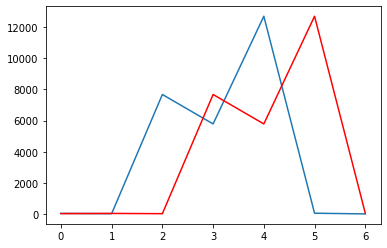

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
series = pd.DataFrame(df.iloc[:,0].values)
# create lagged dataset
values = df.iloc[:,0]
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
    return x
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Train shape', train_X.shape, ' - Test shape:' , test_X)
print('Test RMSE: %.3f' % rmse)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

## AR Model

Train shape (938,)  - Test shape: (484,)
Persistent Model RMSE: 867.478
Prediction Test RMSE: 755.167


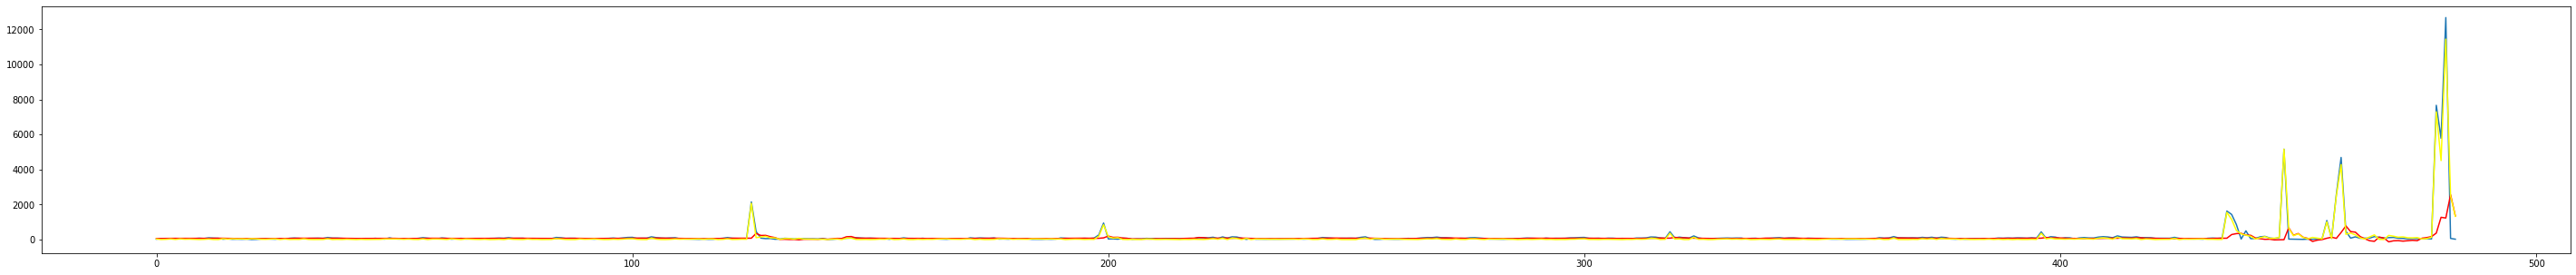

0.0  - FP: 479  - TP: 5  - FPR : 0.9896694214876033  - TPR: 1.0
301.84218861392344  - FP: 16  - TP: 5  - FPR : 0.03305785123966942  - TPR: 1.0
644.5334653132012  - FP: 10  - TP: 4  - FPR : 0.02066115702479339  - TPR: 0.8
2496.5340125221496  - FP: 4  - TP: 3  - FPR : 0.008264462809917356  - TPR: 0.6
4509.455404637594  - FP: 2  - TP: 2  - FPR : 0.004132231404958678  - TPR: 0.4
11441.589124627042  - FP: 0  - TP: 1  - FPR : 0.0  - TPR: 0.2
1000000.0  - FP: 0  - TP: 0  - FPR : 0.0  - TPR: 0.0


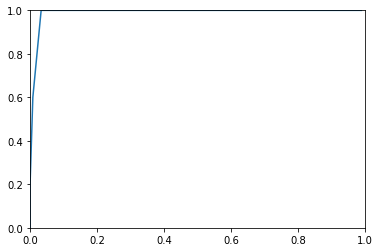

AUC:  0.9797520661157024


In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        print('Persistent Model RMSE: %.3f' % rmse)        


    def __init__(self, path, train_rate):
        df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        series = pd.DataFrame(df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'yellow')
        pyplot.show()

    def get_roc_auc(self, plot=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[df[df['is_anomaly']==1].index - self.train_size]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        # true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            print(threshold,' - FP:', fp,' - TP:',tp, ' - FPR :' ,fpr,' - TPR:', tp/p)

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', 0.66)
ar_model.fit()
ar_model.predict()
ar_model.plot()
ar_model.get_roc_auc()

0.0  - FP: 479  - TP: 5  - FPR : 0.9896694214876033  - TPR: 1.0
301.84218861392344  - FP: 16  - TP: 5  - FPR : 0.03305785123966942  - TPR: 1.0
644.5334653132012  - FP: 10  - TP: 4  - FPR : 0.02066115702479339  - TPR: 0.8
2496.5340125221496  - FP: 4  - TP: 3  - FPR : 0.008264462809917356  - TPR: 0.6
4509.455404637594  - FP: 2  - TP: 2  - FPR : 0.004132231404958678  - TPR: 0.4
11441.589124627042  - FP: 0  - TP: 1  - FPR : 0.0  - TPR: 0.2
1000000.0  - FP: 0  - TP: 0  - FPR : 0.0  - TPR: 0.0


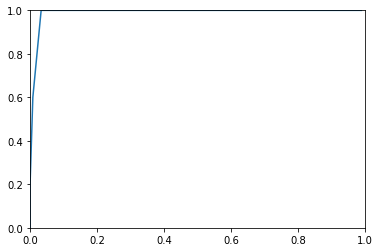

0.9797520661157024

In [0]:
# get the predicted errors of the anomaly points
true_anomaly_predicted_errors = ar_model.errors[df[df['is_anomaly']==1].index - ar_model.train_size]
# sort them 
true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
# true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
# now iterate thru the predicted errors from small to big
# for each value look how much other points have equal or bigger error
FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
TPR = [] # tp/p
p = len(true_anomaly_predicted_errors)
Thresholds = []
for predictederror in true_anomaly_predicted_errors_extended:
    threshold = predictederror
    # detected_anomalies = ar_model.errors[ar_model.error>predictederror]    
    tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
    fp = len(ar_model.errors[ar_model.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
    
    fpr =fp/len(ar_model.errors)
    FPR.append(fpr)
    TPR.append(tp/p)
    print(threshold,' - FP:', fp,' - TP:',tp, ' - FPR :' ,fpr,' - TPR:', tp/p)

import matplotlib.pyplot as plt

plt.figure()
plt.axis([0, 1, 0, 1])
plt.plot(FPR,TPR)
plt.show() 

# This is the AUC
from sklearn.metrics import auc
auc(FPR,TPR)

In [0]:
from sklearn.metrics import auc
auc(FPR,TPR)

0.9797520661157024

In [0]:
true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
true_anomaly_predicted_errors

array([  301.84218861,   644.53346531,  2496.53401252,  4509.45540464,
       11441.58912463])

In [0]:
FPR = [] # fp/(fp+tp)  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
TPR = [] # tp/p
for predictederror in true_anomaly_predicted_errors:
    detected_anomalies = ar_model.errors[ar_model.error>predictederror]    
    len(ar_model.errors[ar_model.error>predictederror])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=predictederror])


In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = # false_positive_rate
y = # true_positive_rate 

# This is the ROC curve
plt.plot(x,y)
plt.show() 

# This is the AUC
auc = np.trapz(y,x)

In [0]:
self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]


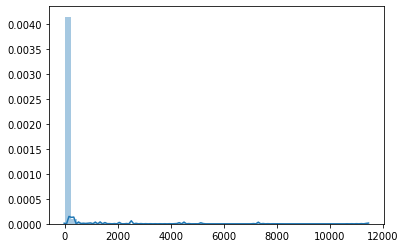

In [0]:
ar_model.errors

import seaborn as sns
sns.distplot(ar_model.errors)

In [0]:
df = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0,parse_dates=True, squeeze=True)
series = pd.DataFrame(df.iloc[:,0].values)  
# split dataset
X = series.values
train_rate =0.66
train, test = X[1:int(len(X) * train_rate)], X[int(len(X) * train_rate):]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.figure(figsize=(50,5))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [0]:
np.percentile(ar_model.errors,98.5)


1944.2956721730625

In [0]:
anomaly_indices = 0
df[df['is_anomaly']==1].index

Int64Index([1387, 1399, 1419, 1420, 1421], dtype='int64', name='timestamp')

In [0]:
np.percentile(A,95)

7.4149999999999965

### Fit model

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = pd.DataFrame(df.iloc[:,0].values)
# split dataset
X = series.values
trainsize = int(len(X) * 0.8)
train, test = X[1:trainsize], X[trainsize:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Train size:',len(train), ' - Test size:',len(test),' - Full size: ', len(X))
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

### Predict with the model

In [0]:
import numpy as np 
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
errors = np.absolute(test.reshape(-1)-predictions)
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.figure(figsize=(50,5))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.plot(errors, color = 'yellow')
pyplot.show()

In [0]:
ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',int(len(X) * 0.66))
ar_model.fit()
ar_model.predict()
ar_model.plot()

### Fit model with detrended data

In [0]:

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
# split dataset
X = df.iloc[:,0].diff().values
X[0] = 0
trainsize = int(len(X) * 0.8)
train, test = X[1:trainsize], X[trainsize:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Train size:',len(train), ' - Test size:',len(test),' - Full size: ', len(X))
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

In [0]:
import numpy as np 
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
errors = np.absolute(test.reshape(-1)-predictions)
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.figure(figsize=(50,5))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.plot(errors, color = 'yellow')
pyplot.show()

In [0]:
predicted_org = np.r_[df.iloc[trainsize-2,0], predictions].cumsum()
test_org = df.iloc[trainsize:,0].values
rmse = sqrt(mean_squared_error(test_org, predicted_org[1:]))
errors = np.absolute(test_org.reshape(-1)-predicted_org[1:])
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.figure(figsize=(50,5))
pyplot.plot(test_org)
pyplot.plot(predicted_org, color='red')
pyplot.plot(errors, color = 'yellow')
pyplot.show()

## MA Model


Prediction Test RMSE: 729.709


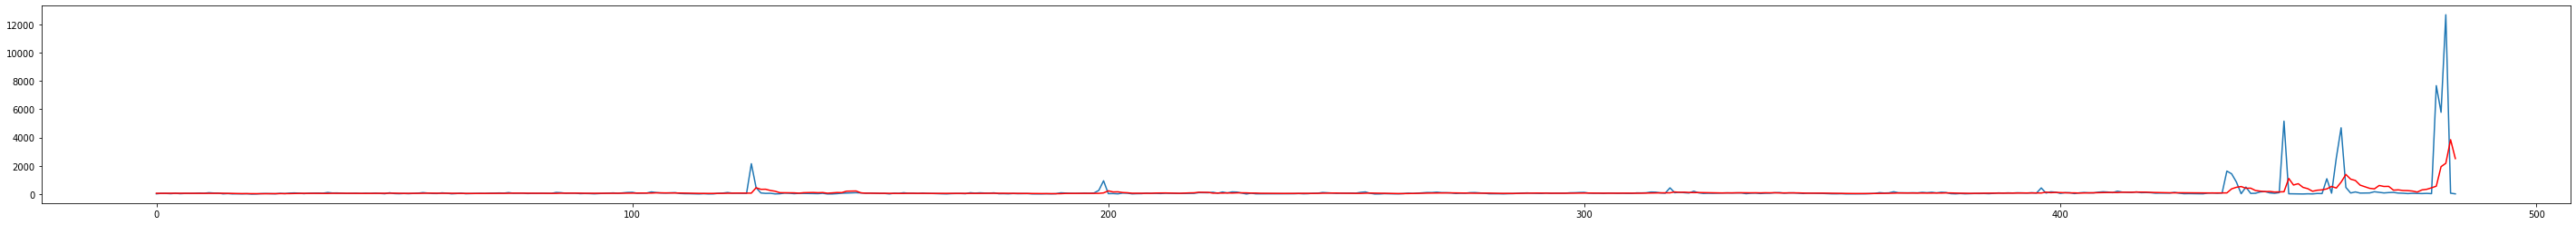

Threshold:                       0.0  - FP:  479 - TP:    5 - FPR:    0.9896694214876033 - TPR:  1.0
Threshold:        301.84218861392344  - FP:   29 - TP:    5 - FPR:   0.05991735537190083 - TPR:  1.0
Threshold:         644.5334653132012  - FP:   13 - TP:    5 - FPR:  0.026859504132231406 - TPR:  1.0
Threshold:        2496.5340125221496  - FP:    3 - TP:    3 - FPR:  0.006198347107438017 - TPR:  0.6
Threshold:         4509.455404637594  - FP:    2 - TP:    1 - FPR:  0.004132231404958678 - TPR:  0.2
Threshold:        11441.589124627042  - FP:    0 - TP:    0 - FPR:                   0.0 - TPR:  0.0
Threshold:                 1000000.0  - FP:    0 - TP:    0 - FPR:                   0.0 - TPR:  0.0


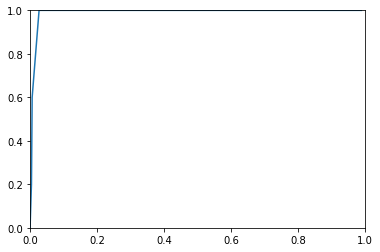

AUC:  0.9805785123966941


In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class MA:
    i = 12345
    def __init__(self, path, train_rate):

        df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        series = pd.DataFrame(df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
        X = self.dataframe.values

        self.train_size = int(len(X) * train_rate)    

        train, test = X[1:self.train_size], X[self.train_size:]
        self.train_X, self.train_y = train[:,0], train[:,1]
        self.test_X, self.test_y = test[:,0], test[:,1]        
        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,4))
        pyplot.plot(self.test_y)
        pyplot.plot(self.predictions, color='red')
        pyplot.show()       

    def get_roc_auc(self, plot=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[df[df['is_anomaly']==1].index - self.train_size]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        # true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

            # print('Threshold: ' , threshold,'\t\t\t\t - FP:', fp,' - TP:',tp, ' - FPR :' ,fpr,' - TPR:', tp/p)

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )

ma_model = MA('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',0.66)
ma_model.fit()
ma_model.predict()
ma_model.plot()
ma_model.get_roc_auc()

Threshold:                       0.0  - FP:  479 - TP:    5 - FPR:    0.9896694214876033 - TPR:  1.0
Threshold:        301.84218861392344  - FP:   16 - TP:    5 - FPR:   0.03305785123966942 - TPR:  1.0
Threshold:         644.5334653132012  - FP:    9 - TP:    5 - FPR:   0.01859504132231405 - TPR:  1.0
Threshold:        2496.5340125221496  - FP:    4 - TP:    3 - FPR:  0.008264462809917356 - TPR:  0.6
Threshold:         4509.455404637594  - FP:    3 - TP:    1 - FPR:  0.006198347107438017 - TPR:  0.2
Threshold:        11441.589124627042  - FP:    1 - TP:    0 - FPR:  0.002066115702479339 - TPR:  0.0
Threshold:                 1000000.0  - FP:    0 - TP:    0 - FPR:                   0.0 - TPR:  0.0


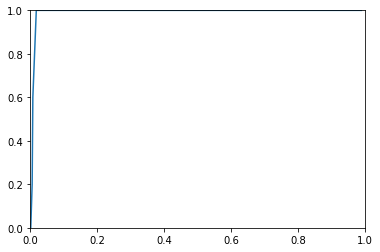

0.9805785123966941

In [0]:
# get the predicted errors of the anomaly points
true_anomaly_predicted_errors = ma_model.errors[df[df['is_anomaly']==1].index - ar_model.train_size]
# sort them 
true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
# true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
# now iterate thru the predicted errors from small to big
# for each value look how much other points have equal or bigger error
FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
TPR = [] # tp/p
p = len(true_anomaly_predicted_errors)
Thresholds = []
for predictederror in true_anomaly_predicted_errors_extended:
    threshold = predictederror
    # detected_anomalies = ar_model.errors[ar_model.error>predictederror]    
    tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
    fp = len(ar_model.errors[ar_model.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
    
    fpr =fp/len(ar_model.errors)
    FPR.append(fpr)
    TPR.append(tp/p)
    print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

import matplotlib.pyplot as plt

plt.figure()
plt.axis([0, 1, 0, 1])
plt.plot(FPR,TPR)
plt.show() 

# This is the AUC
from sklearn.metrics import auc
auc(FPR,TPR)

Test RMSE: 729.709


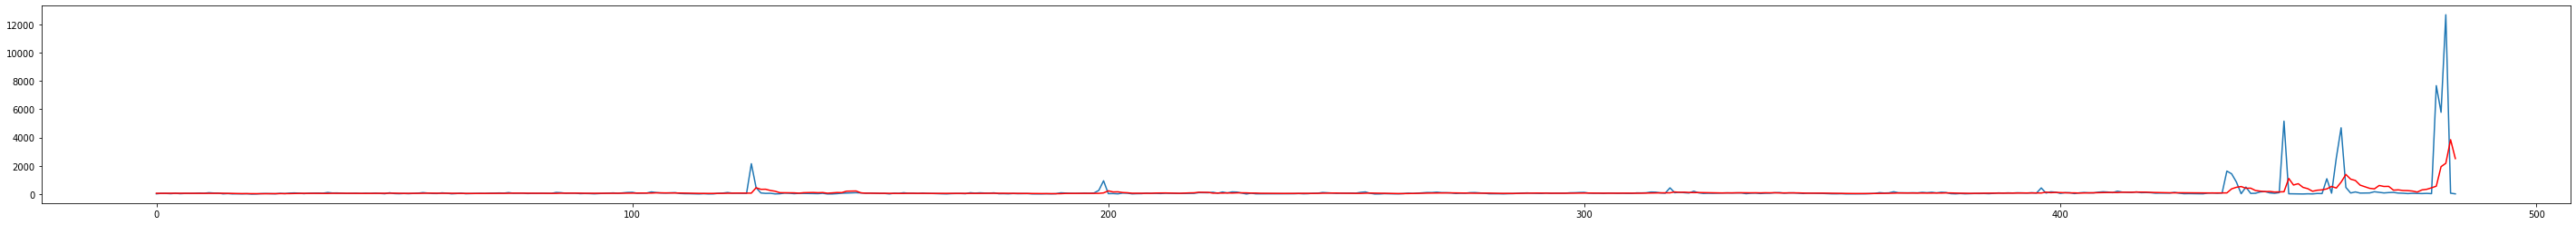

In [0]:
# correct forecasts with a model of forecast residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
# series = read_csv('drive/My Drive/MT/Experiments/Univariate/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
df = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
series = pd.DataFrame(df.iloc[:,0].values)

# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
pyplot.figure(figsize=(50,4))
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()